Vision Transformer (ViT) Architecture

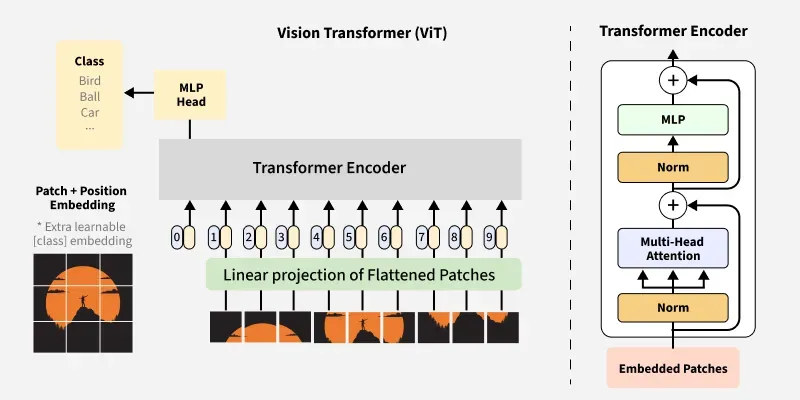

ViT architecture Equations 

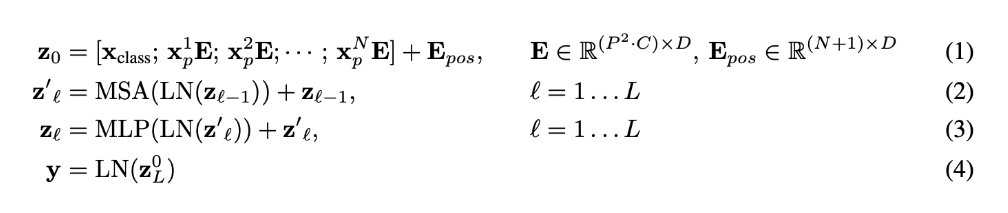

In [ ]:
import torch
import torch.nn as nn
import torchvision
import pathlib as Path
import matplotlib.pyplot as plt
import random
from helper_functions import set_seeds
from torchinfo import summary
from going_modular import engine

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
from pathlib import Path

data_path = Path("data/")

image_path = data_path / "pizza_steak_sushi"

train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

In [6]:
from torchvision import transforms
from going_modular import data_setup

IMG_SIZE = 224

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

manual_transforms

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

In [7]:
# create data loaders

BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1bedbd59350>,
 ['pizza', 'steak', 'sushi'])

In [8]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

(-0.5, 223.5, 223.5, -0.5)

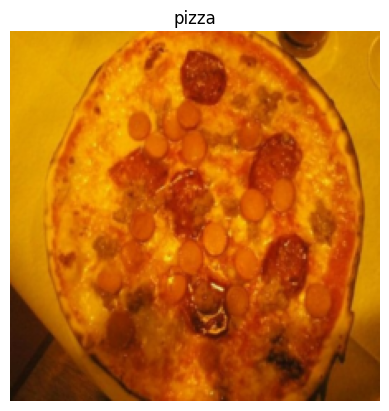

In [9]:
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False)

In [10]:
# Create example values
height = 224 # H ("The training resolution is 224.")
width = 224 # W
color_channels = 3 # C
patch_size = 16 # P

# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)
print(f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patches}")

Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196


Break image to patches

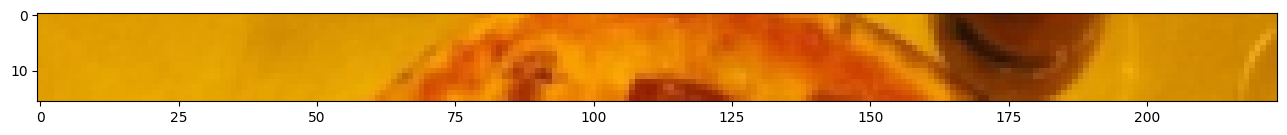

In [11]:
image_permuted = image.permute(1, 2, 0)

patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


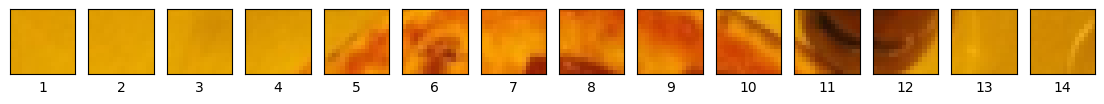

In [12]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size, 
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]); 
    axs[i].set_xlabel(i+1) 
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


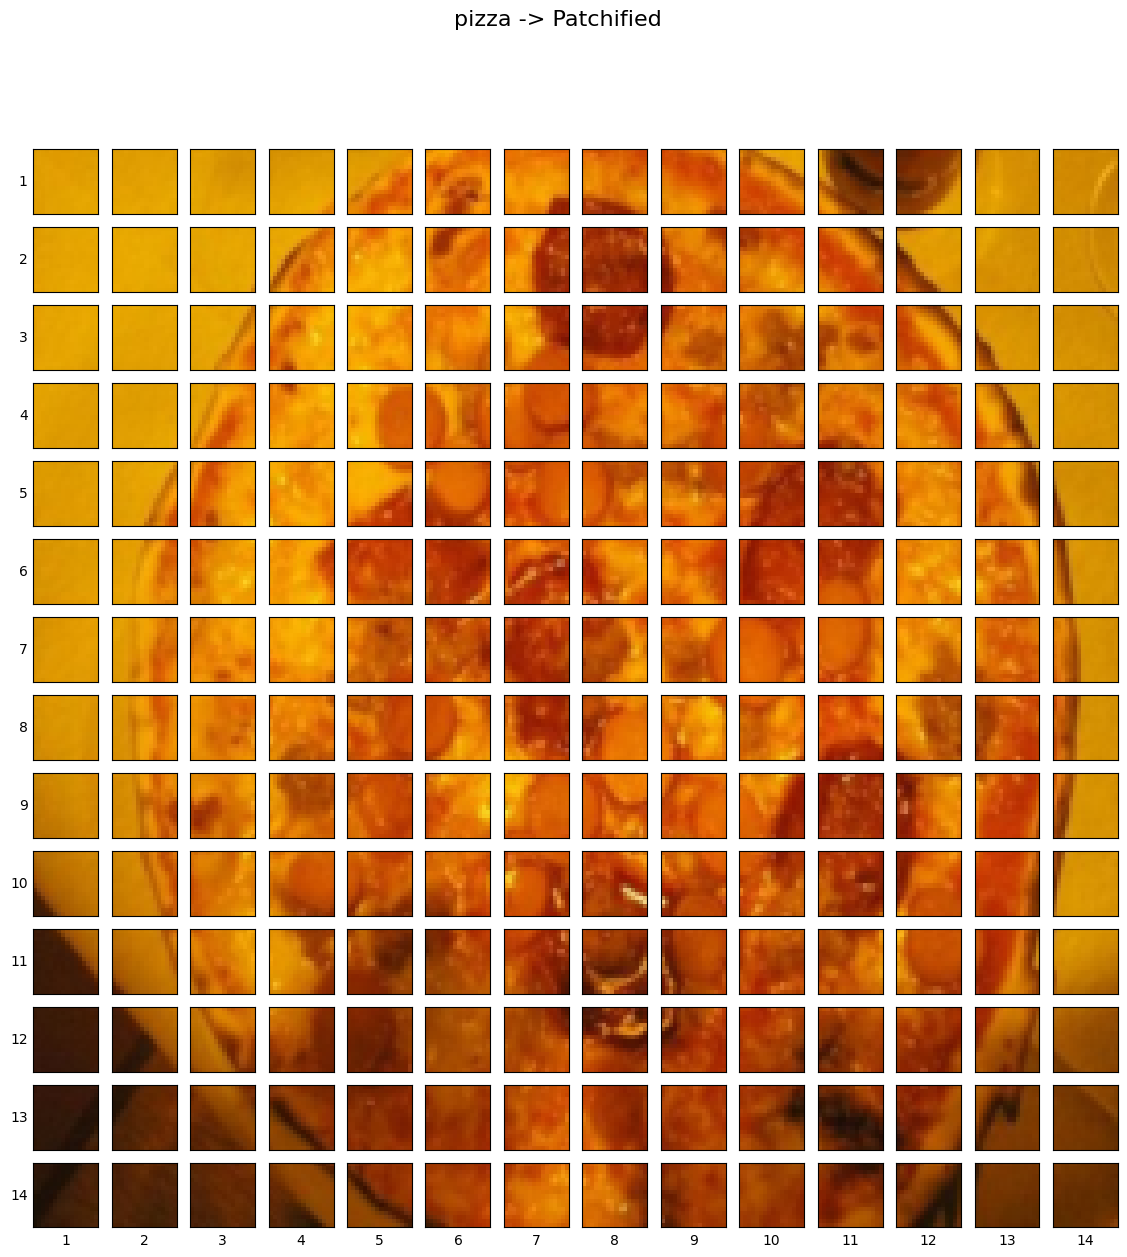

In [13]:
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size, 
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
    for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width

        # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height
                                        patch_width:patch_width+patch_size, # iterate through width
                                        :]) # get all color channels

        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

Create Patch Embeddings

In [14]:
patch_size = 16

conv2d = nn.Conv2d(in_channels=3, # number of color channels
                   out_channels=768, # from Table 1: Hidden size D, this is the embedding size
                   kernel_size=patch_size, # could also use (patch_size, patch_size)
                   stride=patch_size,
                   padding=0)

conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

In [15]:
image_out_of_conv = conv2d(image.unsqueeze(0)) # add a single batch dimension (height, width, color_channels) -> (batch, height, width, color_channels)
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


Showing random convolutional feature maps from indexes: [229, 249, 461, 734, 13]


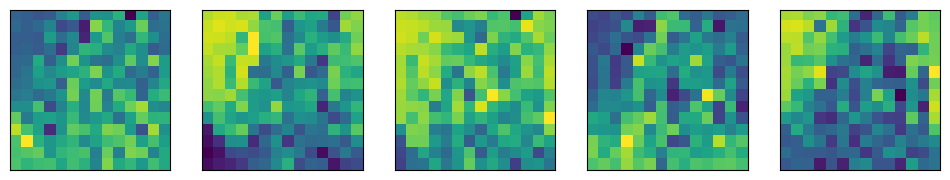

In [16]:
random_indexes = random.sample(range(0, 758), k=5) # pick 5 numbers between 0 and the embedding size
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :]
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

Flattening the patch embedding

In [17]:
# Current tensor shape.
print(f"Current tensor shape: {image_out_of_conv.shape} -> [batch, embedding_dim, feature_map_height, feature_map_width]")

Current tensor shape: torch.Size([1, 768, 14, 14]) -> [batch, embedding_dim, feature_map_height, feature_map_width]


In [18]:
# Create flatten layer
flatten_layer = nn.Flatten(start_dim=2, # flatten feature_map_height (dimension 2)
                     end_dim=3)  # flatten feature_map_width (dimension 3)

flatten_layer(image_out_of_conv).shape

torch.Size([1, 768, 196])

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


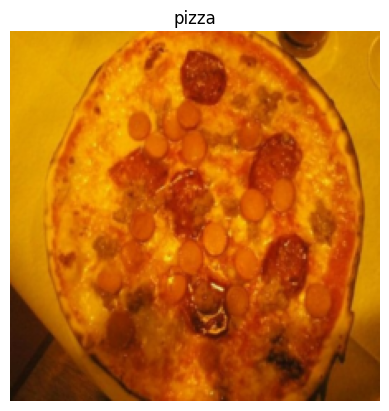

In [19]:
# View single image

plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False)
print(f"Original image shape: {image.shape}")

# Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension to avoid shape errors
print(f"Image feature map shape: {image_out_of_conv.shape}")

# Flatten the feature maps
image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

In [20]:
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


(-0.5, 195.5, 0.5, -0.5)

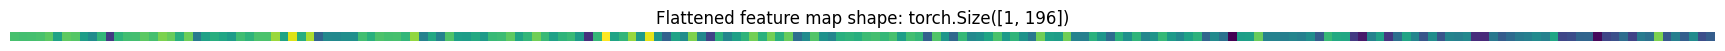

In [21]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0] # index: (batch_size, number_of_patches, embedding_dimension)

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False)

Create patch embedding layer with pytorch 

In [22]:
class PatchEmbedding(nn.Module):
    
    def __init__(self,
                 in_channels: int = 3,
                 patch_size: int = 16,
                 embedding_dim: int = 768):
        
        super().__init__()

        self.patch_size = patch_size  
        self.embedding_dim = embedding_dim  

        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)
        
        self.flatten = nn.Flatten(start_dim=2, end_dim=3)
        
    def forward(self, x):
        image_resolution = x.shape[-1]

        assert image_resolution % self.patch_size == 0, (
            f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"
        )

        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        return x_flattened.permute(0, 2, 1)  

In [23]:
set_seeds(42)

patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) 
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [24]:
# random_input_image_error = (1, 3, 250, 250) # will error because image size is incompatible with patch_size

# patchify(torch.rand(random_input_image_error)) 

Creating the class token embedding

In [25]:
patch_embedded_image, patch_embedded_image.shape

(tensor([[[-0.6937,  0.0846, -0.1186,  ...,  0.3925, -0.3694,  0.2881],
          [-0.6979,  0.0794, -0.1227,  ...,  0.3900, -0.3686,  0.2912],
          [-0.6586,  0.0619, -0.1259,  ...,  0.3724, -0.3610,  0.3127],
          ...,
          [-0.2151, -0.0068, -0.0781,  ...,  0.1114, -0.0379,  0.1517],
          [-0.3277,  0.0145, -0.0394,  ...,  0.1416, -0.1495,  0.1258],
          [-0.2956, -0.0237, -0.0368,  ...,  0.1314, -0.1635,  0.1172]]],
        grad_fn=<PermuteBackward0>),
 torch.Size([1, 196, 768]))

In [26]:
# Get the batch size and embedding dimension.

batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure the embedding is learnable

print(class_token[:, :, :10])

print(f"Class token shape: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension]


In [27]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1) # concat on first dimension


print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.6937,  0.0846, -0.1186,  ...,  0.3925, -0.3694,  0.2881],
         [-0.6979,  0.0794, -0.1227,  ...,  0.3900, -0.3686,  0.2912],
         ...,
         [-0.2151, -0.0068, -0.0781,  ...,  0.1114, -0.0379,  0.1517],
         [-0.3277,  0.0145, -0.0394,  ...,  0.1416, -0.1495,  0.1258],
         [-0.2956, -0.0237, -0.0368,  ...,  0.1314, -0.1635,  0.1172]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


Creating the position embedding

In [28]:
# View the sequence of patch embeddings with the prepended class embedding

patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.6937,  0.0846, -0.1186,  ...,  0.3925, -0.3694,  0.2881],
          [-0.6979,  0.0794, -0.1227,  ...,  0.3900, -0.3686,  0.2912],
          ...,
          [-0.2151, -0.0068, -0.0781,  ...,  0.1114, -0.0379,  0.1517],
          [-0.3277,  0.0145, -0.0394,  ...,  0.1416, -0.1495,  0.1258],
          [-0.2956, -0.0237, -0.0368,  ...,  0.1314, -0.1635,  0.1172]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [29]:
# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)

# Get embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]

position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,
                                             embedding_dimension),
                                  requires_grad=True) # create a learnable parameter

print(position_embedding[:, :10, :10])
print(f"Position embedding shape: {position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Position embedding shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [30]:
# Add the position embedding to the patch and class token embedding

patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch embeddings, class token prepended and positional embeddings added shape: {patch_and_position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.3063, 1.0846, 0.8814,  ..., 1.3925, 0.6306, 1.2881],
         [0.3021, 1.0794, 0.8773,  ..., 1.3900, 0.6314, 1.2912],
         ...,
         [0.7849, 0.9932, 0.9219,  ..., 1.1114, 0.9621, 1.1517],
         [0.6723, 1.0145, 0.9606,  ..., 1.1416, 0.8505, 1.1258],
         [0.7044, 0.9763, 0.9632,  ..., 1.1314, 0.8365, 1.1172]]],
       grad_fn=<AddBackward0>)
Patch embeddings, class token prepended and positional embeddings added shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [31]:
set_seeds()

# Set patch size
patch_size = 16

print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

# Create patch embedding layer.
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# Pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

# Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure it's learnable
print(f"Class token embedding shape: {class_token.shape}")

# Prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# Create position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


Replicating Equation 2 with PyTorch layers

In [32]:
class MultiheadSelfAttentionBlock(nn.Module):
    
    # Initialize the class with hyperparameters from Table 1
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0): # doesn't look like the paper uses any dropout in MSABlocks
        
        super().__init__()

        # Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # Create the Multi-Head Attention (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True) # does our batch dimension come first?

    # Create a forward() method to pass the data through the layers
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, # query embeddings
                                             key=x, # key embeddings
                                             value=x, # value embeddings
                                             need_weights=False) # do we need the weights or just the layer outputs?
        return attn_output

In [33]:
# Create an instance of MSABlock
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=768, # from Table 1
                                                             num_heads=12) # from Table 1

# Pass patch and position image embedding through MSABlock
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])


In [34]:
patch_and_position_embedding

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.3063, 1.0846, 0.8814,  ..., 1.3925, 0.6306, 1.2881],
         [0.3021, 1.0794, 0.8773,  ..., 1.3900, 0.6314, 1.2912],
         ...,
         [0.7849, 0.9932, 0.9219,  ..., 1.1114, 0.9621, 1.1517],
         [0.6723, 1.0145, 0.9606,  ..., 1.1416, 0.8505, 1.1258],
         [0.7044, 0.9763, 0.9632,  ..., 1.1314, 0.8365, 1.1172]]],
       grad_fn=<AddBackward0>)

In [35]:
patched_image_through_msa_block

tensor([[[-0.1766, -0.3458,  0.0050,  ..., -0.2869,  0.8317, -0.3582],
         [-0.1782, -0.3434,  0.0082,  ..., -0.2856,  0.8335, -0.3603],
         [-0.1782, -0.3434,  0.0083,  ..., -0.2856,  0.8335, -0.3604],
         ...,
         [-0.1771, -0.3454,  0.0079,  ..., -0.2850,  0.8337, -0.3602],
         [-0.1779, -0.3443,  0.0082,  ..., -0.2853,  0.8338, -0.3605],
         [-0.1783, -0.3444,  0.0081,  ..., -0.2853,  0.8337, -0.3604]]],
       grad_fn=<TransposeBackward0>)

Replicating Equation 3 with PyTorch layers

In [36]:
class MLPBlock(nn.Module):
    """Creates a layer normalized multilayer perceptron block ("MLP block" for short)."""
    def __init__(self,
                 embedding_dim:int=768, # Hidden Size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 dropout:float=0.1): # Dropout from Table 3 for ViT-Base
        super().__init__()

        # Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # Create the Multilayer perceptron (MLP) layer
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(), # "The MLP contains two layers with a GELU non-linearity (section 3.1)."
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, # needs to take same in_features as out_features of layer above
                      out_features=embedding_dim), # take back to embedding_dim
            nn.Dropout(p=dropout) # "Dropout, when used, is applied after every dense layer"
        )
        
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [37]:
mlp_block = MLPBlock(embedding_dim=768, # from Table 1
                     mlp_size=3072, # from Table 1
                     dropout=0.1) # from Table 3

# Pass output of MSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)

# view shapes
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape MLP block: torch.Size([1, 197, 768])


In [38]:
patched_image_through_msa_block

tensor([[[-0.1766, -0.3458,  0.0050,  ..., -0.2869,  0.8317, -0.3582],
         [-0.1782, -0.3434,  0.0082,  ..., -0.2856,  0.8335, -0.3603],
         [-0.1782, -0.3434,  0.0083,  ..., -0.2856,  0.8335, -0.3604],
         ...,
         [-0.1771, -0.3454,  0.0079,  ..., -0.2850,  0.8337, -0.3602],
         [-0.1779, -0.3443,  0.0082,  ..., -0.2853,  0.8338, -0.3605],
         [-0.1783, -0.3444,  0.0081,  ..., -0.2853,  0.8337, -0.3604]]],
       grad_fn=<TransposeBackward0>)

In [39]:
patched_image_through_mlp_block

tensor([[[ 0.0472, -0.0413,  0.3307,  ..., -0.0000, -0.2176,  0.2782],
         [-0.0677, -0.1596,  0.3981,  ..., -0.1209, -0.1888,  0.2192],
         [ 0.0805, -0.0512,  0.4256,  ..., -0.0000, -0.2379,  0.2284],
         ...,
         [-0.0806, -0.0773,  0.4005,  ...,  0.0512, -0.2714,  0.3236],
         [-0.0029,  0.0082,  0.0000,  ...,  0.0197, -0.2078,  0.1337],
         [-0.0185, -0.0427,  0.3781,  ..., -0.1619, -0.1799,  0.2244]]],
       grad_fn=<MulBackward0>)

Create the Transformer Encoder

In [40]:
class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block."""
    # Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 mlp_dropout:float=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                 attn_dropout:float=0): # Amount of dropout for attention layers
        super().__init__()

        # Create MSA block (equation 2)
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)

        # Create MLP block (equation 3)
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)

    #  Create a forward() method
    def forward(self, x):

        # Create residual connection for MSA block (add the input to the output)
        x =  self.msa_block(x) + x

        # Create residual connection for MLP block (add the input to the output)
        x = self.mlp_block(x) + x

        return x

In [41]:
transformer_encoder_block = TransformerEncoderBlock()

# Print an input and output summary of our Transformer Encoder (uncomment for full output)
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

Creating a Transformer Encoder with PyTorch's Transformer layers

Because of the rise in popularity and effectiveness, PyTorch now has in-built Transformer layers as part of torch.nn.

For example, we can recreate the TransformerEncoderBlock we just created using torch.nn.TransformerEncoderLayer() and setting the same hyperparameters as above.

In [42]:
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768, # Hidden size D from Table 1 for ViT-Base
                                                             nhead=12, # Heads from Table 1 for ViT-Base
                                                             dim_feedforward=3072, # MLP size from Table 1 for ViT-Base
                                                             dropout=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                                                             activation="gelu", # GELU non-linear activation
                                                             batch_first=True, # Do our batches come first
                                                             norm_first=True) # Normalize first or after MSA/MLP layers

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

Putting together to create ViT

In [ ]:
# Create a ViT class that inherits from nn.Module
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    # Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 img_size:int=224, # Training resolution from Table 3 in ViT paper
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0, # Dropout for attention projection
                 mlp_dropout:float=0.1, # Dropout for dense/MLP layers
                 embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                 num_classes:int=1000): # Default for ImageNet but can customize this
        super().__init__() # don't forget the super().__init__()!

        # Make the image size is divisible by the patch size
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

        # Calculate number of patches (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2

        # Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)

        # Create learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)

        # Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        # Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)

        # Create Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential())
        # Note: The "*" means "all"
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

        # Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )

    # Create a forward() method
    def forward(self, x):

        # Get batch size
        batch_size = x.shape[0]

        # Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

        # Create patch embedding (equation 1)
        x = self.patch_embedding(x)

        # Concat class embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1)

        # Add position embedding to patch embedding (equation 1)
        x = self.position_embedding + x

        # Run embedding dropout (Appendix B.1)
        x = self.embedding_dropout(x)

        # Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.transformer_encoder(x)

        # Put 0 index logit through classifier (equation 4)
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x

In [44]:
vit = ViT()
vit

ViT(
  (embedding_dropout): Dropout(p=0.1, inplace=False)
  (patch_embedding): PatchEmbedding(
    (patcher): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (flatten): Flatten(start_dim=2, end_dim=3)
  )
  (transformer_encoder): Sequential(
    (0): TransformerEncoderBlock(
      (msa_block): MultiheadSelfAttentionBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
      )
      (mlp_block): MLPBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
  

In [46]:
set_seeds()

# create a random image tensor with same shape as single image

random_image_tensor = torch.rand((1, 3, 224, 224))

# create instance of ViT model

vit = ViT(num_classes=3)

vit(random_image_tensor)

tensor([[-0.1124,  0.7450,  1.0749]], grad_fn=<AddmmBackward0>)

In [47]:
summary(model=vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 3, 224, 224]    [32, 3]              152,064              True
├─PatchEmbedding (patch_embedding)                           [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                      [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                     [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                           [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                           [32, 197, 768]       [32, 197, 768]

In [ ]:
# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=3e-3, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

